Contenido del directorio 'Logos': ['Logos']
Imagen movida: google-play-music-logo-400x400.png a google
Imagen movida: google-plus-new-icon-logo-400x400.png a google
Imagen movida: google-drive-logo.png a google
Imagen movida: find-us-on-facebook-badge-400x400.png a facebook
Imagen movida: facebook-icon-preview-400x400.png a facebook
Imagen movida: find-us-on-facebook-Badge-vector-download-400x400.jpg a facebook
Imagen movida: youtube-logo.png a youtube
Imagen movida: amazon-alexa-logo.png a amazon
Imagen movida: youtube-button-vector-400x400.png a youtube
Imagen movida: get-it-on-google-play-vector-400x400.png a google
Imagen movida: facebook-icon-logo-vector-400x400.png a facebook
Imagen movida: amazon-logo-preview-400x400.png a amazon
Imagen movida: Google-Calendar-icon.png a google
Imagen movida: google-cloud-logo.png a google
Imagen movida: facebook-logo-preview-400x400.png a facebook
Imagen movida: new-google-maps-logo-vector-download-400x400.jpg a google
Imagen movida: google-plu

100%|██████████| 59/59 [00:00<00:00, 109.35it/s]


Total de descriptores HOG: (59, 1728)


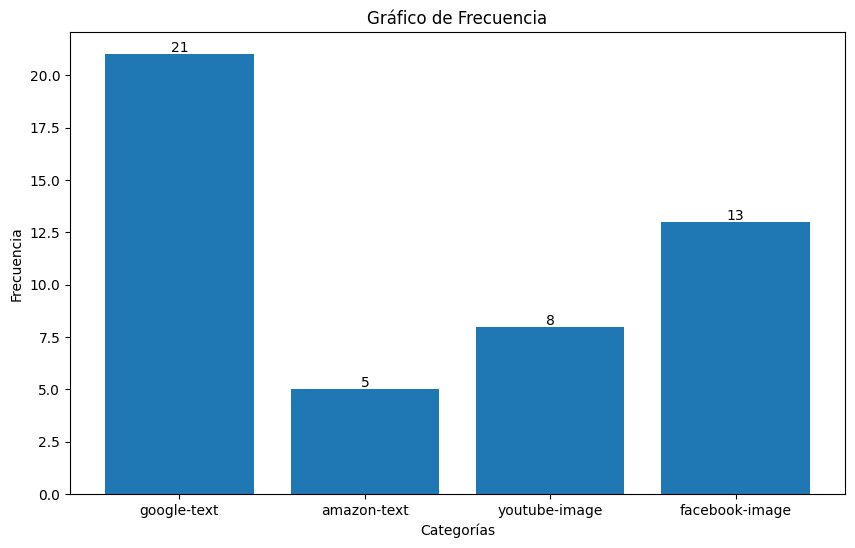

SVM Classifier with gamma = 0.1; Kernel = Polynomial
[LibSVM]
SVM Accuracy:  0.5833
Accuracy: 0.5833
Precision: 0.275
Recall: 0.375
F1: 0.3125

Classification Report:
                 precision    recall  f1-score   support

   amazon-text       0.00      0.00      0.00         1
facebook-image       0.00      0.00      0.00         3
   google-text       0.60      1.00      0.75         6
 youtube-image       0.50      0.50      0.50         2

      accuracy                           0.58        12
     macro avg       0.28      0.38      0.31        12
  weighted avg       0.38      0.58      0.46        12


Confusion Matrix:
 [[0 0 1 0]
 [0 0 2 1]
 [0 0 6 0]
 [0 0 1 1]]
Guardando Objeto en Archivo
Objeto Guardado en Archivo
Modelo SVM guardado con éxito


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [3]:
import os
import zipfile
import numpy as np
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from skimage.feature import hog
from tqdm import tqdm

# Funciones para guardar y cargar objetos pickle
def guardarObjeto(pipeline, nombreArchivo):
    print("Guardando Objeto en Archivo")
    with open(nombreArchivo + '.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Objeto Guardado en Archivo")

def cargarObjeto(nombreArchivo):
    with open(nombreArchivo + '.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
        print("Objeto Cargado desde Archivo")
    return pipeline

# Función para medir la calidad de modelos
def obtenerResultados(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    accuracy = str(round(accuracy, 4))
    precision = str(round(precision, 4))
    recall = str(round(recall, 4))
    f1 = str(round(f1, 4))

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    return accuracy, precision, recall, f1

# Descomprimir el archivo ZIP
def unzip_dataset(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Contenido del directorio '{extract_to}': {os.listdir(extract_to)}")

# Mapeo de etiquetas basado en los nombres de archivos
def get_label_from_filename(filename):
    if 'google' in filename.lower():
        return 'google-text'
    elif 'amazon' in filename.lower():
        return 'amazon-text'
    elif 'facebook' in filename.lower():
        return 'facebook-image'
    elif 'youtube' in filename.lower():
        return 'youtube-image'
    else:
        return None

# Organizar las imágenes en carpetas
def organize_images(image_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    categories = ['google', 'amazon', 'facebook', 'youtube']
    for category in categories:
        category_dir = os.path.join(target_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)

    for image_name in os.listdir(image_dir):
        label = get_label_from_filename(image_name)
        if label:
            category = label.split('-')[0]
            src_path = os.path.join(image_dir, image_name)
            dest_path = os.path.join(target_dir, category, image_name)
            os.rename(src_path, dest_path)
            print(f"Imagen movida: {image_name} a {category}")

# Redimensionar imagen
def resize_image(img):
    return cv.resize(img, (60, 80), interpolation=cv.INTER_LINEAR)

# Cargar y preparar el dataset
def load_images_and_labels(target_dir):
    images = []
    image_labels = []
    for category in os.listdir(target_dir):
        category_dir = os.path.join(target_dir, category)
        for image_name in os.listdir(category_dir):
            label = get_label_from_filename(image_name)
            if label:
                image_path = os.path.join(category_dir, image_name)
                try:
                    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
                    image = resize_image(np.array(image))  # Redimensionar imagen
                    images.append(image)
                    image_labels.append(label)
                    print(f"Imagen cargada: {image_name}, Etiqueta: {label}")
                except Exception as e:
                    print(f"Error al cargar la imagen {image_name}: {e}")
            else:
                print(f"Archivo ignorado (sin etiqueta válida): {image_name}")
    return np.array(images), np.array(image_labels)

# Directorio y archivo ZIP
zip_path = '/content/Logos.zip'
extract_to = 'Logos'

# Descomprimir el archivo ZIP
unzip_dataset(zip_path, extract_to)

# Organizar las imágenes en carpetas
image_dir = os.path.join(extract_to, 'Logos')  # Ajuste del path para apuntar al subdirectorio correcto
target_dir = 'Organized_Logos'
organize_images(image_dir, target_dir)

# Cargar imágenes y etiquetas
images, labels = load_images_and_labels(target_dir)

# Verificar el número de imágenes cargadas y sus etiquetas
print(f"Total de imágenes cargadas: {len(images)}")
print(f"Total de etiquetas cargadas: {len(labels)}")
print(f"Etiquetas únicas: {set(labels)}")

# Verificar si el conjunto de datos está vacío
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No se cargaron imágenes o etiquetas válidas. Verifique los nombres de los archivos y el mapeo de etiquetas.")

# Normalizar y aplicar filtro gaussiano a las imágenes, y calcular HOG
hog_features = []
for image in tqdm(images):
    image = image / 255.0  # Normalizar
    blur = cv.GaussianBlur(image, (5, 5), 0)  # Filtro Gaussiano
    fd, hog_image = hog(blur, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    hog_features.append(fd)
hog_features = np.array(hog_features)

# Verificar el tamaño de los descriptores HOG
print(f"Total de descriptores HOG: {hog_features.shape}")

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42, stratify=labels)

# Análisis de frecuencia de categorías
Y = y_train.tolist()
frecuencias = Counter(Y)
elementos = list(frecuencias.keys())
frecuencias = list(frecuencias.values())

plt.figure(figsize=(10, 6))
plt.bar(elementos, frecuencias)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencia')
plt.xticks(elementos)
for i, v in enumerate(frecuencias):
    plt.text(elementos[i], v + 0.1, str(v), ha='center')
plt.show()

# Desarrollo de SVM
print('SVM Classifier with gamma = 0.1; Kernel = Polynomial')
classifierSVM = SVC(gamma=0.1, kernel='poly', C=1.0, verbose=True)

# Entrenamiento y evaluación en Test
classifierSVM.fit(X_train, y_train)

# Predicciones del conjunto de Test
y_pred = classifierSVM.predict(X_test)
test_acc_svm = accuracy_score(y_test, y_pred)
acc_svm = str(round(test_acc_svm, 4))
print('\nSVM Accuracy: ', acc_svm)

# Obtener resultados detallados
obtenerResultados(y_test, y_pred)

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Guardar el modelo entrenado
guardarObjeto(classifierSVM, 'svm_classifier')

print('Modelo SVM guardado con éxito')
